# Running multiple calculations on a given model


## Aim

This notebook demonstrates how different types of tasks can be connected within a workflow and run a workflow on an external computer. As an example, we start from a structure, optimize its geometry, compute descriptors, then use a filtering function to split the resulting structures into training fles, run Quantum Espresso to get energies on an external system(scarf) and finally run training on the output files. The goal is to show how workflows can be setup to run on external systems.

### Setup

The initial setup is very similar to the other tutorials, such as `singlepoint.ipynb`, which goes into more detail about what each step is doing

Load the aiida profile and code:

In [1]:
from aiida import load_profile
load_profile()

Profile<uuid='5d45845758784527ae91220f374be28a' name='presto'>

In [2]:
from aiida_mlip.data.model import ModelData
uri = "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model"
model = ModelData.from_uri(uri, architecture="mace_mp")

We can load the computer and set the directory in which we want to store the data to. The work directory is a placeholder so change accordingly.

In [3]:
from aiida.orm import load_code, load_computer

janus_code = load_code("janus@localhost")

We must now choose the calculations to perform:

In [4]:
from aiida.plugins import CalculationFactory
geomoptCalc = CalculationFactory("mlip.opt")
descriptorsCalc = CalculationFactory("mlip.descriptors")
trainCalc = CalculationFactory("mlip.train")


Before setting up the work graph, we first configure the `Quantum Espresso (QE)` task by defining the code and input parameters. Since we need to run QE on multiple structures, we create multiple `PwCalculation` tasks dynamically within the same task using `get_current_graph()`. This allows us to run QE for each structure and return the corresponding `TrajectoryData` and parameters for each.

In [5]:
from aiida_workgraph import task
from aiida_workgraph.manager import get_current_graph
from aiida.orm import StructureData, load_group, KpointsData, SinglefileData
from ase.io import iread
from pathlib import Path
import yaml
from aiida_quantumespresso.calculations.pw import PwCalculation
from sample_split import process_and_split_data


@task.graph(outputs = ["test_file", "train_file", "valid_file"])
def qe(**inputs):

    qe_code = load_code("qe@scarf")
    wg = get_current_graph()

    kpoints = KpointsData()
    kpoints.set_kpoints_mesh(inputs['kpoint_mesh'].value)

    pseudo_family = load_group('SSSP/1.3/PBE/efficiency')
    files = {"test_file": inputs['test_file'],"train_file":inputs['train_file'],"valid_file":inputs['valid_file']}

    for file_name, file in files.items():
        with file.as_path() as path:
            for i, structs in enumerate(iread(path, format="extxyz")):
                
                structure = StructureData(ase=structs)
                pseudos = pseudo_family.get_pseudos(structure=structure)

                ecutwfc, ecutrho = pseudo_family.get_recommended_cutoffs(
                    structure=structure,
                    unit='Ry',
                )

                pw_params = {
                    "CONTROL": {
                        "calculation": "scf",
                        'tprnfor': True,
                        'tstress': True,
                    },
                    "SYSTEM": {
                        "ecutwfc": ecutwfc,
                        "ecutrho": ecutrho,
                    },
                }

                qe_task = wg.add_task(
                    PwCalculation,
                    code = qe_code,
                    parameters= pw_params,
                    kpoints= kpoints,
                    pseudos= pseudos,
                    metadata= inputs["calc_metadata"].value,
                    structure= structure,
                )

                structfile = f"{file_name}.struct{i}"
                wg.update_ctx({structfile:{
                    "trajectory":qe_task.outputs.output_trajectory,
                    "parameters": qe_task.outputs.output_parameters
                }})

    return {
        "test_file": wg.ctx.test_file,
        "train_file": wg.ctx.train_file,
        "valid_file": wg.ctx.valid_file
    }    


In [6]:
from aiida_mlip.data.config import JanusConfigfile
from aiida.orm import Dict, TrajectoryData
from ase.io import write
from ase import units

@task.calcfunction(outputs = ["JanusConfigfile"])
def create_train_file(**inputs):

    training_files = {}
    
    for file_name, structs in inputs.items():
        path = Path(f"mlip_{file_name}.extxyz")

        for stuct_out_params in structs.values():
            
            trajectory = stuct_out_params["trajectory"]

            fileStructure = trajectory.get_structure(index=0)
            fileAtoms = fileStructure.get_ase()

            stress = trajectory.arrays["stress"][0]
            converted_stress = stress * units.GPa
            fileAtoms.info["qe_stress"] = converted_stress

            fileAtoms.info["units"] = {"energy": "eV","forces": "ev/Ang","stress": "ev/Ang^3"}
            fileAtoms.set_array("qe_forces", trajectory.arrays["forces"][0])

            parameters = stuct_out_params["parameters"]
            fileParams = parameters.get_dict()
            fileAtoms.info["qe_energy"] = fileParams["energy"]
            write(path, fileAtoms, append=True)

        training_files[file_name] = str(path.resolve())

    with open("JanusConfigfile.yml", "a") as f:
        f.write("\n")
        yaml.safe_dump(training_files, f, sort_keys=False)

    return{'JanusConfigfile': JanusConfigfile(str(Path("JanusConfigfile.yml").resolve()))}

For this task, we are using a task to run a pure python function. This is to demonstrate the flexibility of tasks and how you can run pure python functions on the workchain. This returns `SinglefileData` instances of the test, train and valid files.

In [7]:
@task.calcfunction(outputs = ["test_file", "train_file", "valid_file"])
def create_aiida_files(**inputs):
     
    files = process_and_split_data(**inputs)

    return {
        "train_file": SinglefileData(files["train_file"]),
        "test_file": SinglefileData(files["test_file"]),
        "valid_file": SinglefileData(files["valid_file"])
    }

In [ ]:
from aiida_workgraph import WorkGraph, Zone
from aiida.orm import StructureData
from ase.io import iread
from aiida.orm import Str, Float, Bool, Int, List


initial_structure = "../structures/lj-traj.xyz"

with WorkGraph("QE Calculation Workgraph") as wg:

    final_structures = {}

    calc_inputs = {
        "code": janus_code,
        "model": model,
        "arch": Str(model.architecture),
        "device": Str("cpu"),
        "metadata": {"options": {"resources": {"num_machines": 1}}},
    }

    for i, struct in enumerate(iread(initial_structure)):
        structure = StructureData(ase=struct)

        geomopt_calc = wg.add_task(
            geomoptCalc,
            code=calc_inputs["code"],
            model=calc_inputs["model"],
            arch=calc_inputs["arch"],
            device=calc_inputs["device"],
            metadata=calc_inputs["metadata"],
            fmax=Float(0.1),
            opt_cell_lengths=Bool(False),
            opt_cell_fully=Bool(True),
            struct=structure,
        )

        descriptors_calc = wg.add_task(
            descriptorsCalc,
            code=calc_inputs["code"],
            model=calc_inputs["model"],
            arch=calc_inputs["arch"],
            device=calc_inputs["device"],
            metadata=calc_inputs["metadata"],
            struct=geomopt_calc.outputs.final_structure,
            calc_per_element=True,
        )

        final_structures[f"structs{i}"] = descriptors_calc.outputs.xyz_output

    split_task_inputs = {
        "trajectory_data": final_structures,
        "config_types": Str(""),
        "n_samples": Int(len(final_structures)),
        "prefix": Str(""),
        "scale": Float(1.0e5),
        "append_mode": Bool(False),
    }

    split_task = wg.add_task(create_aiida_files, inputs=split_task_inputs)

    qe_inputs = {
        "test_file": split_task.outputs.test_file,
        "train_file": split_task.outputs.train_file,
        "valid_file": split_task.outputs.valid_file,
        "calc_metadata":  Dict({
                "options": {
                    "resources": {
                        "num_machines": 1,
                        'num_mpiprocs_per_machine': 32,
                    },
                    'max_wallclock_seconds': 3600,
                    'queue_name': 'scarf',                  
                    'qos': 'scarf',
                    'environment_variables': {},
                    'withmpi': True,                       
                    'prepend_text': '''
                    module purge
                    module use /work4/scd/scarf562/eb-common/modules/all
                    module load amd-modules
                    module load QuantumESPRESSO/7.2-foss-2023a
                    ''',
                    'append_text': ''  
                }
            }),
            "kpoint_mesh": List([1,1,1])
        }

    qe_task = wg.add_task(qe, name="QE_workflow", **qe_inputs)

    qe_files = {
        "test_file": qe_task.outputs.test_file,
        "train_file": qe_task.outputs.train_file,
        "valid_file": qe_task.outputs.valid_file
    }

    training_files = wg.add_task(create_train_file, **qe_files)

    train_task = wg.add_task(
        trainCalc,
        mlip_config = training_files.outputs.JanusConfigfile,
        code = janus_code,
        metadata={'options': {"resources": {"num_machines": 1}}},
        fine_tune =True,
        foundation_model= model
    )

defining outputnode
defining outputnode


Visualise the workgraph

In [9]:
wg


NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'QE Calc…

In [10]:
wg.run()

10/23/2025 10:55:50 AM <2303472> aiida.broker.rabbitmq: [WARNING] RabbitMQ v3.12.1 is not supported and will cause unexpected problems!
10/23/2025 10:55:50 AM <2303472> aiida.broker.rabbitmq: [WARNING] It can cause long-running workflows to crash and jobs to be submitted multiple times.
10/23/2025 10:55:50 AM <2303472> aiida.broker.rabbitmq: [WARNING] See https://github.com/aiidateam/aiida-core/wiki/RabbitMQ-version-to-use for details.
10/23/2025 10:55:56 AM <2303472> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [7175|WorkGraphEngine|continue_workgraph]: tasks ready to run: GeomOpt,GeomOpt1,GeomOpt2,GeomOpt3,GeomOpt4,GeomOpt5,GeomOpt6,GeomOpt7,GeomOpt8,GeomOpt9,GeomOpt10,GeomOpt11,GeomOpt12,GeomOpt13,GeomOpt14,GeomOpt15
10/23/2025 10:56:02 AM <2303472> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [7175|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 7179, 7183, 7187, 7191, 7195, 7199, 7203, 7207, 7211, 7215, 7219, 7223,

create files: train_file=PosixPath('train.xyz'), valid_file=PosixPath('valid.xyz') and test_file=PosixPath('test.xyz')
Processing: ('all', 'aiida'), 16 frames
  ('all', 'aiida'): total=16, train_target=12,                     vt_target=4


/home/mtr46585/aiida-mlip/.venv/lib/python3.12/site-packages/fpsample/wrapper.py:98: UserWarning: k is too large, set to 16
  warnings.warn(f"k is too large, set to {n_pts}")
/home/mtr46585/aiida-mlip/.venv/lib/python3.12/site-packages/fpsample/wrapper.py:98: UserWarning: k is too large, set to 4
  warnings.warn(f"k is too large, set to {n_pts}")
10/23/2025 11:00:03 AM <2303472> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [7175|WorkGraphEngine|update_task_state]: Task: create_aiida_files, type: CALCFUNCTION, finished.
10/23/2025 11:00:03 AM <2303472> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [7175|WorkGraphEngine|continue_workgraph]: tasks ready to run: QE_workflow
10/23/2025 11:00:06 AM <2303472> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [7175|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 7581
10/23/2025 11:00:08 AM <2303472> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPO

{}

In [11]:
wg.tasks.Train.outputs

TaskSocketNamespace(name='outputs', sockets=['remote_folder', 'remote_stash', 'retrieved', 'model', 'compiled_model', 'results_dict', 'logs', 'checkpoints', '_outputs', '_wait'])

If we want to get the training plot, we have to pull it from the remote folder.  

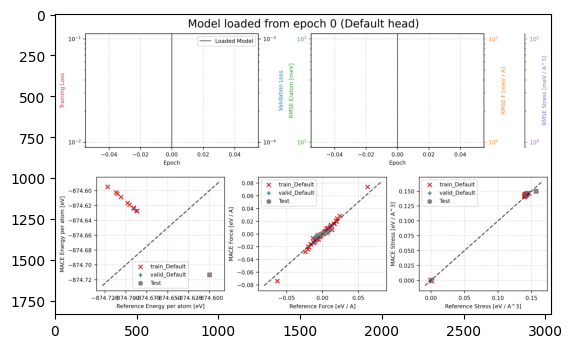

In [12]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


folder = wg.tasks.Train.outputs.remote_folder.value
picturePath = f"{os.getcwd()}/traingraph.png"
folder.getfile(relpath='results/test_run-123_train_Default_stage_one.png',destpath=picturePath)

img = mpimg.imread(picturePath)
plt.imshow(img)